In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import IPython.display as Disp
from ipywidgets import widgets

In [2]:
# some functions for looking into the tiff files
## a simple script to read multipage tiff files
def read_tiff(path,ROI_coordinates=None, n_images=100000):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)

    images = []
    #dimensions = np.diff(ROI_coordinates.T).T[0]+1
    for i in range(10000000):
        try:
            img.seek(i)
            img.getpixel((1, 1))
            imarray = np.array(img)
            if ROI_coordinates:
                slice_ = imarray[ROI_coordinates[0][1]:ROI_coordinates[1][1]+1,ROI_coordinates[0][0]:ROI_coordinates[1][0]+1]
                images.append(slice_)
            else:
                images.append(imarray)
            
           # break
        except EOFError:
            # Not enough frames in img
            break
    return np.array(images)

# jupyter notebook bounding box drawing (prateek khandelwal - https://medium.com/@khandelwalprateek01/how-to-select-roi-in-jupyter-notebook-309fe5185a54)
class bbox_select():
    %matplotlib notebook 
    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),7)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

def moving_average(a, n=3) : # moving average 
    if n>2:
        begn = int(np.ceil(n/2))
        endn = int(n-begn)-1
        a = np.concatenate([a[begn::-1],a,a[:-endn:-1]])
    ret = np.cumsum(a,axis = 0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Accessing a movie data and metadata
The data is arranged in subfolders: /'subject_id'/'cell_id'/'movie_name'/

select subject, cell and movie based on the directory structure:

In [3]:
ground_truth_basedir = '/home/rozmar/Data/Voltage_imaging/ground_truth' # location of the data
subject_id = '456462'
cell_id = 'Cell_5'
movie  = '40x_1xtube_10A5'
movie_dir = os.path.join(ground_truth_basedir , subject_id , cell_id , movie)
movie_dir

'/home/rozmar/Data/Voltage_imaging/ground_truth/456462/Cell_5/40x_1xtube_10A5'

The movie metadata (framerate, pixel size) is in the movie_metadata.json file in the main movie directory.

In [4]:
with open(os.path.join(movie_dir,'movie_metadata.json')) as json_file:
    movie_metadata = json.load(json_file)
movie_metadata

{'movie_frame_num': 50000,
 'movie_frame_rate': 401.60642570281124,
 'movie_name': '40x_1xtube_10A5',
 'movie_number': 3,
 'movie_pixel_size': 0.59,
 'movie_start_time': 376.2986300000048,
 'movie_x_size': 512.0,
 'movie_y_size': 128.0,
 'session': 1,
 'subject_id': 456462}

The actual movie files are in the movie subfolder, these are multitiff files chunked to 300MB each <br>
Let's read the first 5 movies

In [5]:
movie_files_dir = os.path.join(movie_dir,'movie')
movie_files = os.listdir(movie_files_dir)
movie_files = sorted(movie_files)

movie_list = list()
for movie_file in movie_files[:13]:
    print('reading {}'.format(movie_file))
    movie_list.append(read_tiff(os.path.join(movie_files_dir,movie_file)))
movie_raw = np.concatenate(movie_list)
background = np.min(movie_raw)
movie_raw_mean= np.mean(movie_raw,0)

reading 40x_1xtube_10A5_000.tif
reading 40x_1xtube_10A5_001.tif
reading 40x_1xtube_10A5_002.tif
reading 40x_1xtube_10A5_003.tif
reading 40x_1xtube_10A5_004.tif
reading 40x_1xtube_10A5_005.tif
reading 40x_1xtube_10A5_006.tif
reading 40x_1xtube_10A5_007.tif
reading 40x_1xtube_10A5_008.tif
reading 40x_1xtube_10A5_009.tif
reading 40x_1xtube_10A5_010.tif
reading 40x_1xtube_10A5_011.tif
reading 40x_1xtube_10A5_012.tif


<IPython.core.display.Javascript object>


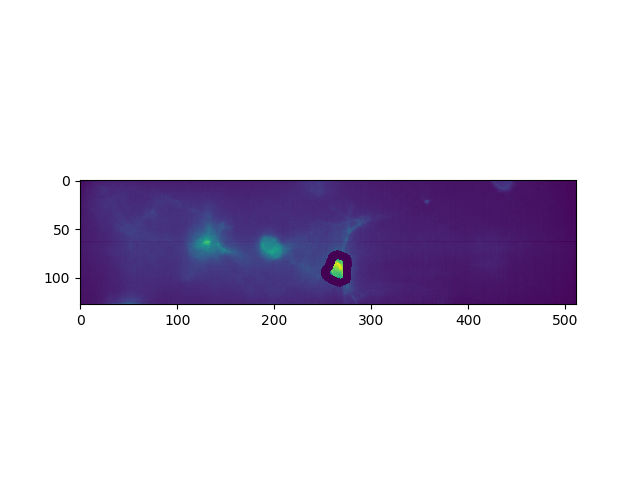

Button(description='Disconnect mpl', style=ButtonStyle())

In [6]:
# Select ROI
%matplotlib notebook
bs = bbox_select(movie_raw_mean)

In [7]:
F0_length = 5 # seconds
F0_step = round(movie_metadata['movie_frame_rate']*F0_length)
arr = np.array([bs.selected_points],'int')
mask = cv2.fillPoly(np.zeros(movie_raw_mean.shape,np.uint8),arr,[1,1,1])
F = np.mean(movie_raw[:,np.where(mask)[0],np.where(mask)[1]],1)-background
F0 = moving_average(F,F0_step)
dff = (F-F0)/F0

The frame times (relative to the ephys recording) is in the frame_times.npy file.

In [8]:
frame_times = np.load(os.path.join(movie_dir,'frame_times.npy'))
frame_times = frame_times[:len(dff)]

# Accessing the ephys data
The ephys files are in the ephys subfolder.

In [9]:
ephys_files_dir = os.path.join(movie_dir,'ephys')
ephys_files = sorted(os.listdir(ephys_files_dir))
ephys_files

['sweep_56.json',
 'sweep_56.npz',
 'sweep_57.json',
 'sweep_57.npz',
 'sweep_58.json',
 'sweep_58.npz',
 'sweep_59.json',
 'sweep_59.npz',
 'sweep_60.json',
 'sweep_60.npz']

Reading the sweeps is just iterating over the files

In [10]:
sweep_time = list()
sweep_response = list()
sweep_stimulus = list()
sweep_metadata = list()
for ephys_file in ephys_files:
    if ephys_file[-3:]=='npz':
        data_dict = np.load(os.path.join(ephys_files_dir,ephys_file))
        sweep_time.append(data_dict['time'])
        sweep_response.append(data_dict['voltage'])
        sweep_stimulus.append(data_dict['stimulus'])
        with open(os.path.join(ephys_files_dir,ephys_file[:-3]+'json')) as json_file:
            sweep_metadata.append(json.load(json_file))     
sweep_metadata[0] # here is an example of a sweep metadata

{'bridgebalenable': 1,
 'bridgebalresist': 50000000.0,
 'cell_number': 5,
 'data_header': ['time', 'voltage', 'stimulus'],
 'data_units': ['s', 'mV', 'pA'],
 'fastcompcap': 8.4134e-42,
 'fastcomptau': 8.4134e-42,
 'holding': 0.0,
 'holdingenable': 0,
 'leaksubenable': 1,
 'leaksubresist': 8.4134e-42,
 'ljp': 13.5,
 'ljp_corrected': True,
 'neutralizationcap': 6.02496e-12,
 'neutralizationenable': 1,
 'outputzeroamplitude': 0.0,
 'outputzeroenable': 0,
 'pipetteoffset': -0.0711719,
 'primarysignalhpf': 0.0,
 'primarysignallpf': 21000.0,
 'protocol_name': 'cont_001',
 'protocol_sweep_number': 0,
 'recording_mode': 'current clamp',
 'rscompbandwidth': 8.4134e-42,
 'rscompcorrection': 8.4134e-42,
 'rscompenable': 1,
 'sample_rate': 10000,
 'session': 1,
 'slowcompcap': 8.4134e-42,
 'slowcomptau': 8.4134e-42,
 'subject_id': 456462,
 'sweep_end_time': 388.86945,
 'sweep_number': 56,
 'sweep_start_time': 358.869455,
 'wholecellcompcap': 8.4134e-42,
 'wholecellcompenable': 1,
 'wholecellcompre

# Plotting ephys and ophys data.

Text(0, 0.5, 'Stimulus (pA)')

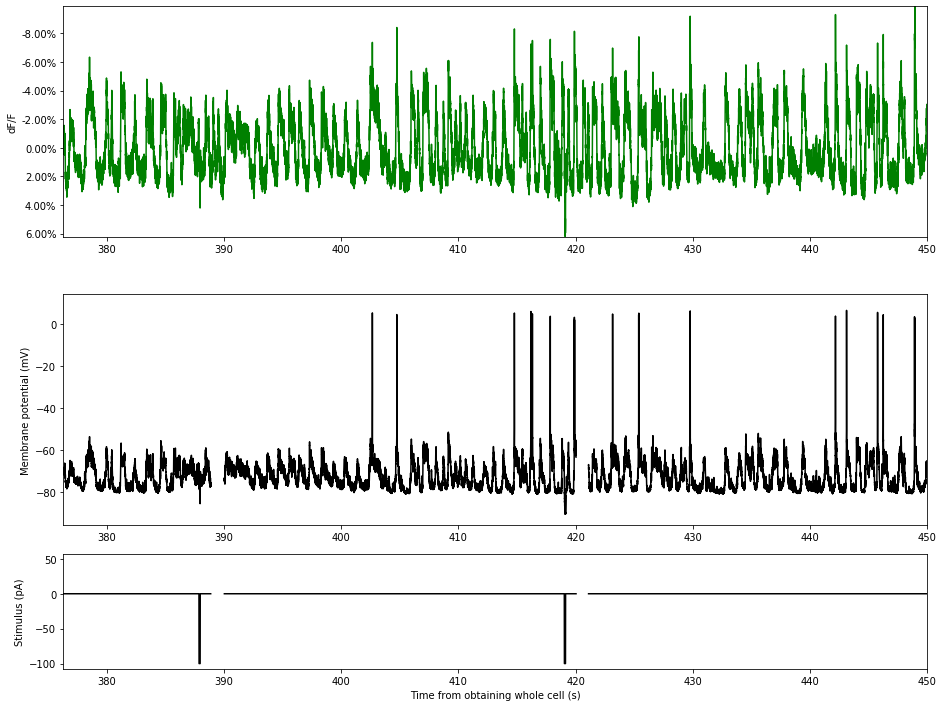

In [11]:
%matplotlib inline
xlimits = [frame_times[0],frame_times[-1]]
#xlimits = [400, 405]
fig=plt.figure()
ax_ephys = fig.add_axes([0,0,2,.8])
ax_stim = fig.add_axes([0,-.5,2,.4])
for time,response,stimulus in zip(sweep_time,sweep_response,sweep_stimulus):
    ax_ephys.plot(time,response,'k-')
    ax_stim.plot(time,stimulus,'k-')
if dff is not None:
    ax_ophys = fig.add_axes([0,1,2,.8])

    ax_ophys.plot(frame_times,dff,'g-')
    ax_ophys.autoscale(tight = True)
    ax_ophys.invert_yaxis()
    ax_ophys.set_xlim(xlimits)
    ax_ophys.set_ylabel('dF/F')
    vals = ax_ophys.get_yticks()
    ax_ophys.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    
ax_ephys.set_xlim(xlimits)
ax_ephys.set_ylabel('Membrane potential (mV)')
ax_stim.set_xlim(xlimits)
ax_stim.set_xlabel('Time from obtaining whole cell (s)')
ax_stim.set_ylabel('Stimulus (pA)')